# How to stream results from your RAG application

This guide explains how to stream results from a [RAG](/docs/concepts/rag/) application. It covers streaming tokens from the final output as well as intermediate steps of a chain (e.g., from query re-writing).

We'll work off of the Q&A app with sources we built over the [LLM Powered Autonomous Agents](https://lilianweng.github.io/posts/2023-06-23-agent/) blog post by Lilian Weng in the [RAG tutorial](/docs/tutorials/rag).

## Setup

### Dependencies

We'll use the following packages:

In [1]:
%pip install --upgrade --quiet  langchain langchain-community langchainhub beautifulsoup4

### LangSmith

Many of the applications you build with LangChain will contain multiple steps with multiple invocations of LLM calls. As these applications get more and more complex, it becomes crucial to be able to inspect what exactly is going on inside your chain or agent. The best way to do this is with [LangSmith](https://smith.langchain.com).

Note that LangSmith is not needed, but it is helpful. If you do want to use LangSmith, after you sign up at the link above, make sure to set your environment variables to start logging traces:

```python
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()
```

### Components

We will need to select three components from LangChain's suite of integrations.

A [chat model](/docs/integrations/chat/):

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs customVarName="llm" />

In [2]:
# | output: false
# | echo: false

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

An [embedding model](/docs/integrations/text_embedding/):

import EmbeddingTabs from "@theme/EmbeddingTabs";

<EmbeddingTabs/>

In [3]:
# | output: false
# | echo: false

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

And a [vector store](/docs/integrations/vectorstores/):

import VectorStoreTabs from "@theme/VectorStoreTabs";

<VectorStoreTabs/>

In [4]:
# | output: false
# | echo: false

from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

## RAG application

Let's reconstruct the Q&A app with sources we built over the [LLM Powered Autonomous Agents](https://lilianweng.github.io/posts/2023-06-23-agent/) blog post by Lilian Weng in the [RAG tutorial](/docs/tutorials/rag).

First we index our documents:

In [6]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [7]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

Next we build the application:

In [8]:
from langchain import hub
from langchain_core.documents import Document
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

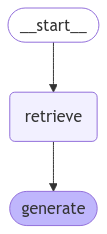

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Streaming final outputs

LangGraph supports several [streaming modes](https://langchain-ai.github.io/langgraph/how-tos/#streaming), which can be controlled by specifying the `stream_mode` parameter. Setting `stream_mode="messages"` allows us to stream tokens from chat model invocations.

In general there can be multiple chat model invocations in an application (although here there is just one). Below, we filter to only the last step using the name of the corresponding node:

In [10]:
input_message = "What is Task Decomposition?"

for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"},
    # highlight-next-line
    stream_mode="messages",
):
    if metadata["langgraph_node"] == "generate":
        print(message.content, end="|")

|Task| De|composition| is| a| technique| used| to| break| down| complex| tasks| into| smaller|,| more| manageable| steps|.| It| often| involves| prompting| models| to| "|think| step| by| step|,"| allowing| for| clearer| reasoning| and| better| performance| on| intricate| problems|.| This| can| be| achieved| through| various| methods|,| including| simple| prompts|,| task|-specific| instructions|,| or| human| input|.||

## Streaming intermediate steps

Other streaming modes will generally stream steps from our invocation-- i.e., state updates from individual nodes. In this case, each node is just appending a new key to the state:

In [11]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"},
    # highlight-next-line
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='5bf5e308-6ccb-4f09-94d2-d0c36b8c9980', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='d8aed221-7943-414d-8ed7-63c2b0e7523b', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reaso

For more on streaming with LangGraph, check out its [streaming documentation](https://langchain-ai.github.io/langgraph/how-tos/#streaming). For more information on streaming individual LangChain [Runnables](/docs/concepts/runnables/), refer to [this guide](/docs/how_to/streaming/).